# Neural Style Transfer

Suggested by Leon A Gatys, Neural Style Transfer is a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm produces new images of high perceptual quality that combine the content of an arbitrary photograph with the appearance of numerous wellknown artworks.

This consists of 3 main components, namely: the Original Image (OI) or the Content Image; the Style Image (SI) and the Target/ Generated Image (GI) which is a combination of the Content Image and the Style Image.

In [ ]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu available to process faster
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale the image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
  '''This function loads the required image, adds a dimension to it and then returns the image'''
  image = Image.open(image_name)
  # add fake batch dimension to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

#Load content image
content_img = image_loader("/content/Real_woman.jpg")

#Load style image
style_img = image_loader("/content/Monet.jpg")

#Inspect the reshaped sizes of the style and content images 
print('Size of style image', style_img.size())
print('Size of content image', content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Size of style image torch.Size([1, 3, 512, 512])
Size of content image torch.Size([1, 3, 512, 512])


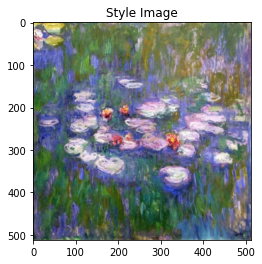

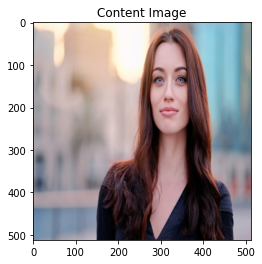

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image from Tensor

plt.ion()

def imshow(tensor, title=None):
  '''Function to display the image'''
  image = tensor.cpu().clone()  # clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension added earlier
  image = unloader(image)       # Convert to PIL image
  plt.imshow(image)             # Now display teh image
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


# Content Reconstruction 
The aim is to get the summary of content of original image so that the Generated image is close enough to pixels to look like the Original image but distant enough to capture the key brushstrokes or style.

Now, in order to achieve this, pass the Content Image/ Original Image through a pretrained CNN to be able to extract activations and then find the Mean Square Error (MSE)not between raw pixels but between the activation values calculated by forward pass of layer of choice. 

The choice of layer would depend on how much of the original image you'd want to keep:
1. Earlier layers: are very close to raw pixels so they carry information very similar to the original image.
2. Later layers: contain more condensed and complex information because of the reshaping of poling and the non linearities it goes through.

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)   # Calculates the mse between Content Image and Target Image activations
        return input

#Style Reconstruction
To understand this, we first need to understand what the term Style even means. In simple words, it could be described as the sharp, geometric, textural semi abstract strokes.

Capturing style is not as simple as just minimizing of MSE between the activations of the style and the original image. Thus, a Gram Matrix is created to capture the style of the image. A Gram Matrix is a Matrix of activations of each Convolutional Layer. It is obtained by flattening the activations into a 2D matrix which is then correlated with itself. 

Why the Gram Matrix works in capturing style of the iamge? 
1. We need to get rid of the spatial information of the style image since its not the semantics of the image that we are interested in; thus flatteing the 2D filters and multiplying them is a good way to mess up the spatial ordering.
2. It provides an idea of which features appear as standalone elements, or together with other features or don't appear at all. 

Mean Square Error ( MSE) is then calculated between the Gram Matrices of the Random Noise Image and the Style Image. 


In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps / no. of channels
    # (c,d)=dimensions of a f. map (N=c*d) -- flatten 2D map activation map

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    #print("Features", features)

    G = torch.mm(features, features.t())  # compute the gram product --- performs matrix multiplication to
                                          # calculate correlations between features

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() # 'detach' the target content to dynamically compute the gradient
                                                           # not a variable. Otherwise the forward method of the criterion
                                                           # will throw an error.

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)             # Calculate mse between the two gram matrices 
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
cnn.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

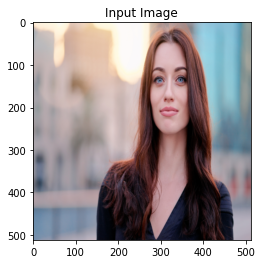

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [50]:
Style Loss : 39.658916 Content Loss: 12.926369

run [100]:
Style Loss : 13.657422 Content Loss: 12.150038

run [150]:
Style Loss : 6.043573 Content Loss: 11.235344

run [200]:
Style Loss : 2.708734 Content Loss: 10.564508

run [250]:
Style Loss : 1.532103 Content Loss: 9.914150

run [300]:
Style Loss : 1.068600 Content Loss: 9.420986



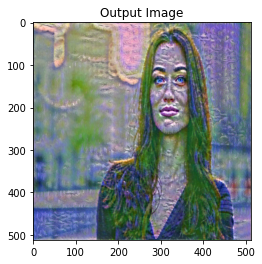

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()